In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import pandas as pd

# AGMS Functions

In [3]:
# Using base 4 dyadic ranges
class DyadicRange:
        
    def __init__(self, low, high):
        self.low = low
        self.high = high
        lev = np.log(np.abs(high-low)+1)/np.log(4)
        lev_int = int(lev)
        if lev_int != lev:
            raise Exception("ERROR: not a dyadic range! Level cannot be "+str(lev))
        self.level = lev_int
        self.index = int(np.floor(low/(4**self.level))) 
        
    def __str__(self):
        return "[ "+str(self.low)+", "+str(self.high)+" ]"+" : level = "+str(self.level)+" , index = "+str(self.index)
            
class numericRange:
    
    def __init__(self, low, high):
            self.low = low
            self.high = high
            
    def __str__(self):
        return "[ "+str(self.low)+", "+str(self.high)+" ]"
    
def minimalDyadicCover(low, high):
        j = 0
        D = list()
        while low <= high:
            low_level_limit = int(low/4**(j+1))*4**(j+1)
            if low_level_limit != low:
                low_level_limit += 4**(j+1)
                while low_level_limit != low:
                    if low > high:
                        break
# #                     print("LOW "+str(j)+" : "+str(low)+" - "+str(low+4**j-1))
                    D.append(DyadicRange(low,low+4**j-1))
                    low = low+4**j
                    
                
            high_level_limit = (int(high/4**(j+1))+1)*4**(j+1)-1
            if high_level_limit != high:
                high_level_limit -= 4**(j+1)
                while high_level_limit != high:
                    if low > high:
                        break
#                     print("HIGH "+str(j)+" : "+str(high-4**j+1)+" - "+str(high))
                    D.append(DyadicRange(high-4**j+1,high))
                    high = high-4**j
            j+=1
        return np.asarray(D)

In [4]:
class simple_EH3_HashFunction:
    def __init__(self, seed=42, bits=31):
#         no negative integers
        assert(bits <= 31)
        self.bits = int(bits)-1
        self.s0 = np.random.randint(0, 2)
        self.S0 = np.random.randint(0,int(2**self.bits-1), dtype='int32')        
        
    def parity(self, int_type):
        int_type ^= (int_type >> 16)
        int_type ^= (int_type >> 8)
        int_type ^= (int_type >> 4)
        int_type ^= (int_type >> 2)
        int_type ^= (int_type >> 1)
        return (int_type & 1)
    
    def eh3(self, v):        
        mask = 0xAAAAAAAA
        h = self.parity((v | (v<<1)) & mask)
#         print("{} -> {}".format(v, self.parity(self.S0 & v)))
        
        x = self.s0 ^ self.parity(self.S0 & v) ^ h
        if x == 0:
            return -1
        else:
            return 1
    
    def eh3_range(self, index, level):
        v = index*(4**level)
        assert(v < 2**32-1)
        e = self.eh3(v)
#         print("{} -> {}".format(v, e))

        #If level == 0, we are done
        if level == 0:
            return e

        zeross = "{0:032b}".format(self.S0)
        zeros = 0
        for i in range(0,2*level,2):
            if zeross[len(zeross)-i-1] == '0' and zeross[len(zeross)-i-2] == '0':
                zeros += 1
        return e * (-1)**(zeros) * 2**level                
    
    def hash_interval(self, low, high):
        D =  minimalDyadicCover(low,high)
        result = 0
        
        for d in D:
            result += self.eh3_range(d.index, d.level)
        return result
                    
            
    def __str__(self):
        return "H3HashFunctions\nnumFunctions = "+str(self.numFunctions)+"\nseeds = "+str(self.seeds)


In [5]:
class EH3_HashFunction:
    def __init__(self, numEstimators=1, numCounters=1, seed=42, bits=31, json_dic=None):
        if json_dic == None:
#         no negative integers
            assert(bits <= 31)
            self.numEstimators = numEstimators
            self.numCounters = numCounters

            self.bits = int(bits)-1
            self.s0 = np.random.randint(0, 2, size=(numEstimators, numCounters))
            self.S0 = np.random.randint(0,int(2**self.bits-1), size=(numEstimators, numCounters), dtype='int32')
        else:
            self.numEstimators = json_dic["numEstimators"]
            self.numCounters = json_dic["numCounters"]
            self.bits = json_dic["bits"] 
            self.s0 = np.asarray(json_dic["s0"])
            self.S0 = np.asarray(json_dic["S0"])    
        
    def parity(self, int_type):
        int_type ^= (int_type >> 16)
        int_type ^= (int_type >> 8)
        int_type ^= (int_type >> 4)
        int_type ^= (int_type >> 2)
        int_type ^= (int_type >> 1)
        return (int_type & 1)
    
    def eh3(self, v):        
        mask = 0xAAAAAAAA
        h = self.parity((v | (v<<1)) & mask)
#         print("{} -> {}".format(v, self.parity(self.S0 & v)))
        
        x = self.s0 ^ self.parity(self.S0 & v) ^ h
        x[x == 0] = -1
        
        return x
    
    def eh3_range(self, index, level):
        v = index*(4**level)
        assert(v < 2**32-1)
        e = self.eh3(v)
        
#         print("{} -> {}".format(v, e))

        #If level == 0, we are done
        if level == 0:
            return e

        zeros = self.get_zeros(level)
                
        return e * (-1)**(zeros) * 2**level    
    
    def get_zeros(self, level):
        zeros = np.zeros(self.S0.shape)
        for k, row in enumerate(self.S0):
            for j, S0 in enumerate(row):
                zeross = "{0:032b}".format(S0)
                for i in range(0,2*level,2):
                    if zeross[len(zeross)-i-1] == '0' and zeross[len(zeross)-i-2] == '0':
                        zeros[k,j] += 1
        return zeros
    
    def hash_interval(self, low, high):
        D =  minimalDyadicCover(low,high)
        result = np.zeros(self.S0.shape)
        
        for d in D:
            result += self.eh3_range(d.index, d.level)
        return result
                    
            
    def __str__(self):
        return "H3HashFunctions\nnumFunctions = "+str(self.numFunctions)+"\nseeds = "+str(self.seeds)


In [9]:
class AGMS_Old:
    
    def __init__(self, numCounters, numEstimators, seed=42):
#     def __init__(self, eps=0.001, delta=0.01, seed=42):
        self.seed = seed
#         self.numCounters = int(np.ceil(1/eps**2))
#         self.numEstimators = int(np.ceil(np.log(1.0/delta)))
        self.numCounters = numCounters
        self.numEstimators = numEstimators
        
        self.eh3_hashfunctions = np.empty((self.numEstimators,self.numCounters), dtype=object)
        for i, row in enumerate(self.eh3_hashfunctions):
            for j, cell in enumerate(row):
                self.eh3_hashfunctions[i,j] = simple_EH3_HashFunction()
#             print(self.eh3_hashfunctions[i].S0)
        self.estimators = np.zeros((self.numEstimators, self.numCounters))
        
    def update(self, val, weight=1):
        for i, row in enumerate(self.eh3_hashfunctions):
            for j, cell in enumerate(row):
                self.estimators[i,j] += self.eh3_hashfunctions[i,j].eh3(val)*weight
            
    def estimate_frequency(self, low, high):
        filterSketch = self.range_filter_sketch(low, high)
        f2 = np.average(filterSketch*self.estimators, axis=1)
        return np.median(f2)
    
    def range_filter_sketch(self, low, high):
        result = np.zeros(self.estimators.shape)
        for i, row in enumerate(self.eh3_hashfunctions):
            for j, cell in enumerate(row):
                result[i,j] = self.eh3_hashfunctions[i,j].hash_interval(low, high)
        return result
            
    def __str__(self):
        return "FastAGMS\nnumEstimators = {}\nnumCounters = {}\nestimators = {}".format(self.numEstimators, self.numCounters, self.estimators)

In [6]:
DEFAULT_EPS = 0.01
DEFAULT_DELTA = 0.01
DEFAULT_EPS = 0.01
DEFAULT_EPS = 0.01

class AGMS:
    
    def __init__(self, numCounters, numEstimators, seed=42, json_dic=None):
        if json_dic == None:
#     def __init__(self, eps=0.01, delta=0.01, seed=42):
            self.seed = seed

            self.numCounters = numCounters
            self.numEstimators = numEstimators
    #         self.numCounters = int(np.ceil(1/eps**2))
    #         self.numEstimators = int(np.ceil(np.log(1.0/delta)))

    #         print("{} : {}".format(self.numCounters, self.numEstimators))
            self.eh3_hashfunctions = EH3_HashFunction(self.numEstimators, self.numCounters)

            self.estimators = np.zeros((self.numEstimators, self.numCounters), dtype=int)
        else:
            self.seed = json_dic["seed"]
            self.numCounters = json_dic["numCounters"]
            self.numEstimators = json_dic["numEstimators"]
            self.eh3_hashfunctions = EH3_HashFunction(json_dic=json_dic["eh3_hashfunctions"])
            self.estimators = json_dic["estimators"]
        
    def update(self, val, weight=1):
        self.estimators += self.eh3_hashfunctions.eh3(val)*weight
            
    def estimate_frequency(self, low, high):
        filterSketch = self.range_filter_sketch(low, high)
        f2 = np.average(filterSketch*self.estimators, axis=1)
        return np.median(f2)

    def range_filter_sketch(self, low, high):
        return self.eh3_hashfunctions.hash_interval(low, high)

    def query_buckets(self, buckets):
        result = np.zeros(len(buckets))
        i = 0
        for b in buckets:
            result[i] = self.estimate_frequency(b.low, b.high)
            i+=1
        return result
    
    def getBinFrequencies(self, minimum, maximum, nBins):
        buckets = calculateBinRanges(minimum, maximum, nBins)
        return self.query_buckets(buckets)
            
    def __str__(self):
        return "FastAGMS\nnumEstimators = {}\nnumCounters = {}\nestimators = {}".format(self.numEstimators, self.numCounters, self.estimators)

In [11]:
class AGMSEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, EH3_HashFunction):
            return dict(numEstimators=obj.numEstimators, numCounters=obj.numCounters, s0=obj.s0, S0=obj.S0, bits=obj.bits)
        if isinstance(obj, AGMS):
            return dict(seed=obj.seed, numCounters=obj.numCounters, numEstimators=obj.numEstimators, 
                        eh3_hashfunctions=obj.eh3_hashfunctions, estimators=obj.estimators)
        return json.JSONEncoder.default(self, obj)

In [27]:
numCounters = 1024
numEstimators = 10

agms = AGMS(numCounters, numEstimators)

m = 100
n = 400
values = np.random.randint(m, size=n)
for val in values:    
    agms.update(val)

In [33]:
agms.estimate_frequency(1, 20)

[74.4609375  82.33203125 80.25       75.5234375  83.60546875 82.8515625
 85.84765625 84.3984375  88.3359375  87.62109375]


83.228515625

In [30]:
jsonStr = json.dumps(agms.__dict__, indent=2, cls=AGMSEncoder)
text_file = open("json/test.json", "w")
n1 = text_file.write(jsonStr)
text_file.close()
print(jsonStr)

{
  "numEstimators": 10, 
  "seed": 42, 
  "numCounters": 1024, 
  "eh3_hashfunctions": {
    "numEstimators": 10, 
    "bits": 30, 
    "S0": [
      [
        16162469, 
        205614457, 
        924113854, 
        888982870, 
        317162659, 
        855932475, 
        94222977, 
        50481440, 
        602037665, 
        1011198224, 
        837378253, 
        852917102, 
        405327222, 
        129963646, 
        468619780, 
        689682277, 
        980251159, 
        712564797, 
        661554068, 
        794450168, 
        362085561, 
        1064237445, 
        708369881, 
        113810723, 
        1073470929, 
        71340229, 
        100702174, 
        439116980, 
        579155160, 
        331699892, 
        108956796, 
        857386197, 
        455036010, 
        972894520, 
        772109762, 
        581439466, 
        564846129, 
        536187533, 
        569717474, 
        173504455, 
        565888459, 
        491244038, 
        

In [13]:
numCounters = 1024
numEstimators = 10

agms = AGMS(numCounters, numEstimators)
jsonStr = json.dumps(agms.__dict__, indent=2, cls=AGMSEncoder)
print(jsonStr)

{
  "numEstimators": 10, 
  "seed": 42, 
  "numCounters": 1024, 
  "eh3_hashfunctions": {
    "numEstimators": 10, 
    "bits": 30, 
    "S0": [
      [
        466432991, 
        115783728, 
        674342524, 
        331801492, 
        706363576, 
        759115494, 
        455760066, 
        358249110, 
        140923314, 
        20847683, 
        552096873, 
        636285689, 
        27594376, 
        395904975, 
        288058293, 
        478780023, 
        5121047, 
        738228072, 
        346812104, 
        732561471, 
        356895047, 
        51336809, 
        247355695, 
        414339750, 
        549649248, 
        227504, 
        889913634, 
        941882978, 
        967582659, 
        323823989, 
        452467769, 
        682637278, 
        770119929, 
        283344495, 
        85645487, 
        312551512, 
        1049496497, 
        687563518, 
        230905064, 
        233303810, 
        251221443, 
        813654746, 
        1234989

In [32]:
numCounters = 1024
numEstimators = 10

agms = AGMS(numCounters, numEstimators)
# agms_2 = AGMS_Old(numCounters, numEstimators)

# for i in np.arange(0, numEstimators):
#     print("s0: {} | S0: {}".format(fAGMS.eh3_hashfunctions.s0[i], fAGMS.eh3_hashfunctions.S0[i]))

# for i, row in enumerate(fAGMS_2.eh3_hashfunctions):
#     for j, cell in enumerate(row):
#         agms_2.eh3_hashfunctions[i,j].S0 = agms.eh3_hashfunctions.S0[i,j]
#         agms_2.eh3_hashfunctions[i,j].s0 = agms.eh3_hashfunctions.s0[i,j]

m = 100
n = 50000
counter = np.zeros(m)
values = np.random.randint(m, size=n)

start = time.time()
for val in values:    
    agms.update(val)
end = time.time()
print(end - start)

# start = time.time()
# for val in values:
#     fAGMS_2.update(val)
# end = time.time()
# print(end - start)
    
for val in values:
    counter[val] += 1
    
low = 31
high = 77
res = 0
for i in range(low, high+1):
    res += counter[i]

estimate = agms.estimate_frequency(low, high)
# estimate_2 = agms_2.estimate_frequency(low, high)

print(res)
print(estimate)
# print(estimate_2)
print("---------------")
print(np.abs(res-estimate))

23.2878239155
23308.0
23343.580078125
---------------
35.580078125


# Bar chart Range-Summable EH3

In [7]:
def calculateBucketRanges(minimum, maximum, bucketSize):
    buckets = list()
    current = minimum
    while current+bucketSize <= maximum:
        buckets.append(numericRange(current, current+bucketSize-1))
        current += bucketSize
    return np.asarray(buckets)

# def calculateBinRanges(minimum, maximum, nBins):
#     buckets = list()
#     binSize = (maximum-minimum)/nBins
#     current = minimum
#     while current+binSize < maximum:
#         buckets.append(numericRange(current, current+binSize-1))
#         current += binSize
#     return np.asarray(buckets)

def count_buckets(exactCounter, buckets):
    result = np.zeros(len(buckets))
    i = 0
    for b in buckets:
        for element in np.arange(b.low, b.high+1):
            result[i] += exactCounter[element]
        i+=1
    return result

In [8]:
def create_and_compare_histogram(minimum, maximum, bucketSize, agms, exactCounter, nElements=1):
    buckets = calculateBucketRanges(minimum, maximum, bucketSize)

    x = np.arange(len(buckets))  # the label locations
    width = 0.4  # the width of the bars
    
    estimates = agms.query_buckets(buckets)
    counts = count_buckets(exactCounter, buckets)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    rects1 = ax.bar(x - width/2, estimates, width, label='AGMS Sketch estimate')
    rects2 = ax.bar(x + width/2, counts, width, label='Exact Counts')
    ax.set_xlabel('buckets')
    ax.set_ylabel('frequency')
    ax.set_xticks(x)
    plt.xticks(rotation=90)
    ax.set_xticklabels(buckets)

    count = estimates.shape[0]
    errorSum = 0.0
    maxError = 0.0
    for i, est in enumerate(estimates):
        diff = np.abs(estimates[i]-counts[i])
        errorSum += diff
        if diff > maxError:
            maxError = diff
        
    print("AGMS Sketch:\nAbsolute error mean: "+str(errorSum/count))
    print("Relative error mean: "+str(errorSum/count/nElements))
    print("Absolute error max: "+str(maxError))
    print("Relative error max: "+str(maxError/nElements))


    ax.legend(loc = 'upper left')

    plt.show()

In [35]:
n = 10000

numCounters = 1024
numEstimators = 5

agms = AGMS(numCounters, numEstimators)

counts = np.zeros(n)
m = 50000
for i in np.arange(m):
    element = np.random.randint(n)
    counts[element] += 1
    agms.update(element)


AGMS Sketch:
Absolute error mean: 638.703125
Relative error mean: 0.0127740625
Absolute error max: 993.6015625
Relative error max: 0.01987203125


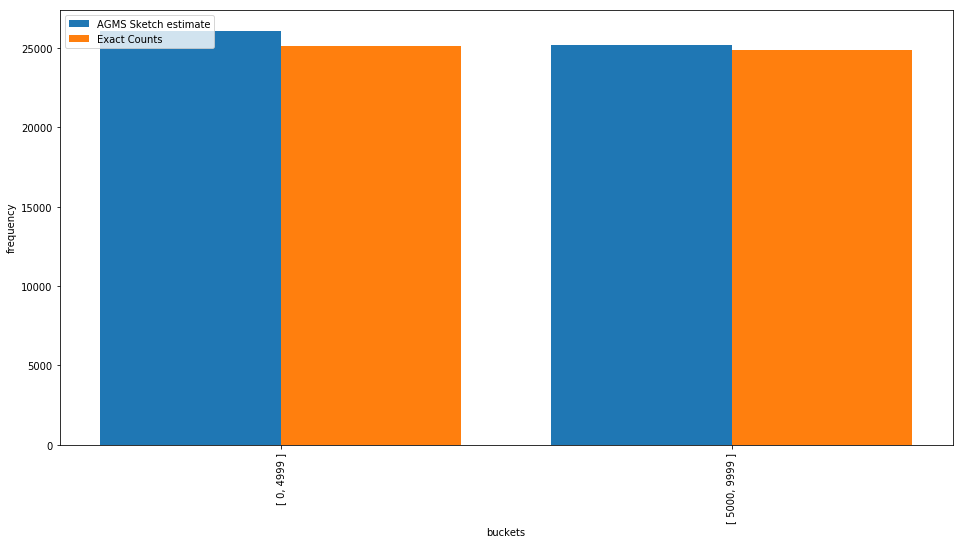

In [36]:
create_and_compare_histogram(0, n, 5000, agms, counts, m)

AGMS Sketch:
Absolute error mean: 204.61171875
Relative error mean: 0.004092234375
Absolute error max: 518.984375
Relative error max: 0.0103796875


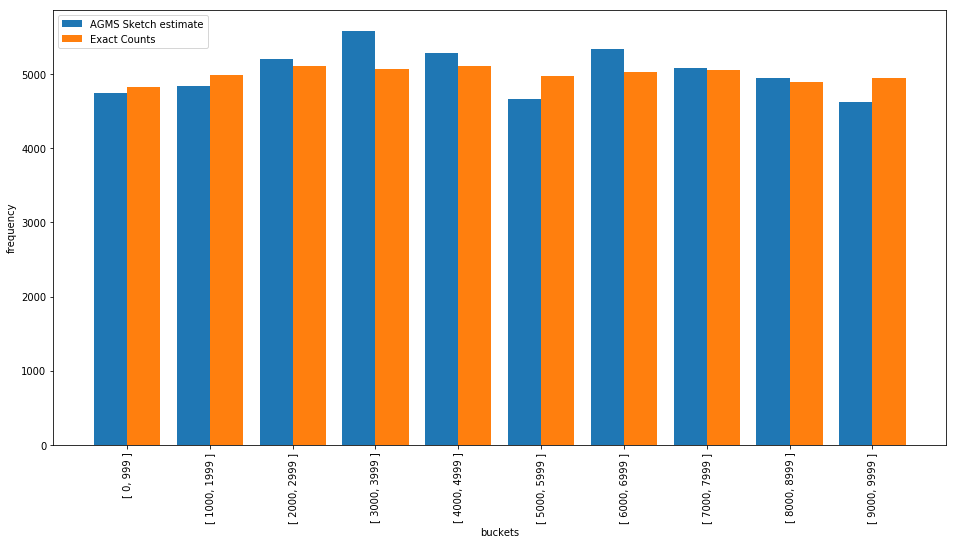

In [37]:
create_and_compare_histogram(0, n, 1000, agms, counts, m)

AGMS Sketch:
Absolute error mean: 78.4443359375
Relative error mean: 0.00156888671875
Absolute error max: 243.59765625
Relative error max: 0.004871953125


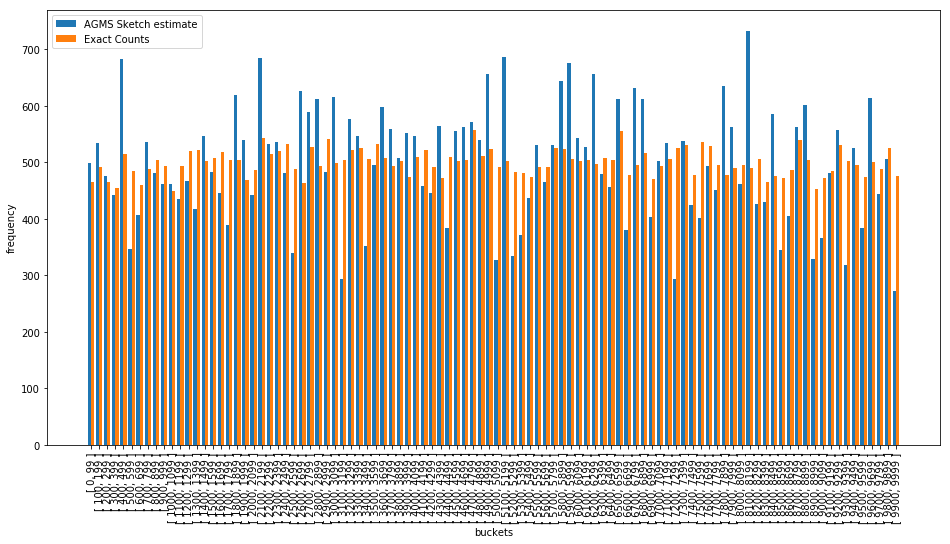

In [38]:
create_and_compare_histogram(0, n, 100, agms, counts, m)

AGMS Sketch:
Absolute error mean: 7.38328125
Relative error mean: 0.000147665625
Absolute error max: 30.37109375
Relative error max: 0.000607421875


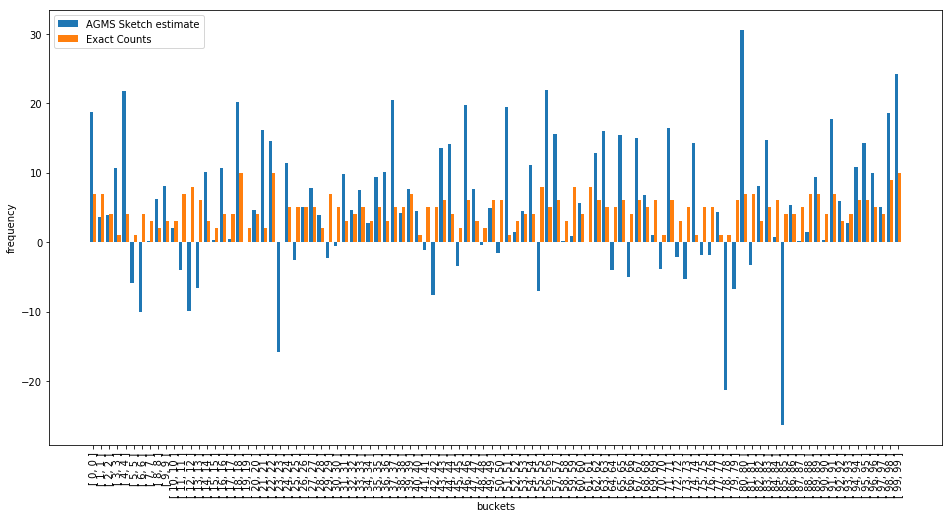

In [39]:
create_and_compare_histogram(0, 100, 1, agms, counts, m)

# Heat-Map Range-Summable EH3

In [9]:
class numericGrid:
    
    def __init__(self, x_low, x_high, y_low, y_high):
            self.x_low = x_low
            self.x_high = x_high
            self.y_low = y_low
            self.y_high = y_high
            
    def __str__(self):
        return "y [ "+str(self.y_low)+", "+str(self.y_high)+" ] x [ "+str(self.x_low)+", "+str(self.x_high)+" ]"

def calculateGridRanges(x_minimum, x_maximum, y_minimum, y_maximum, bucketSize):
    grids = list()
    y_current = y_minimum + bucketSize*int((y_maximum-y_minimum)/bucketSize)-1
    x_current = x_minimum
    
    while y_current >= y_minimum:
        while x_current < x_maximum:
            grids.append(numericGrid(x_current, x_current+bucketSize-1, y_current-bucketSize+1, y_current))
            x_current += bucketSize
        x_current = x_minimum
        y_current -= bucketSize        
    return np.asarray(grids).reshape(int((y_maximum-y_minimum)/bucketSize), int((x_maximum-x_minimum)/bucketSize))

def count_grids(exactCounter, mean, scale, grids):
    result = np.zeros(np.shape(grids))
    i = 0
    k = 0
    for row in grids:
        for cell in row:
#             print(str(cell.x_low)+" x "+ str(cell.x_high))
#             print(str(cell.y_low)+" y "+ str(cell.y_high))
            for x in np.arange(cell.x_low, cell.x_high+1):
                for y in np.arange(cell.y_low, cell.y_high+1):
                    x_origin = x-(mean-2*scale)
                    y_origin = y-(mean-2*scale)
                    result[k,i] += exactCounter[x_origin,y_origin]
            i+=1
        i = 0
        k += 1
    return result

In [53]:
class TupleAGMS_Old:
    
    def __init__(self, numCounters, numEstimators, seed=42, x_max_index=2**31-1):
#     def __init__(self, eps=0.01, delta=0.01, seed=42, x_max_index=2**31-1):
        self.seed = seed
#         self.numCounters = int(np.ceil(1/eps**2))
#         self.numEstimators = int(np.ceil(np.log(1.0/delta)))
        self.numCounters = numCounters
        self.numEstimators = numEstimators
#         print("{} : {}".format(self.numCounters, self.numEstimators))
        self.eh3_hashfunctions = EH3_HashFunction(self.numEstimators, self.numCounters)
        
        self.estimators = np.zeros((self.numEstimators, self.numCounters))
        self.x_max_index = x_max_index
        
    def update(self, x, y, weight=1):
        val = y*self.x_max_index+x
        self.estimators += self.eh3_hashfunctions.eh3(val)*weight
    
    def estimate_grid_frequency(self, grid):
        filterSketch = np.zeros(self.estimators.shape)
        for y in np.arange(grid.y_low, grid.y_high+1):
            low = y*self.x_max_index+grid.x_low
            high = y*self.x_max_index+grid.x_high
            filterSketch += self.eh3_hashfunctions.hash_interval(low, high)
            
        f2 = np.average(filterSketch*self.estimators, axis=1)
        return np.median(f2)
            
    def query_grids(self, grids):
        frequencies = np.zeros(grids.shape)
        for k, row in enumerate(grids):
            for i, grid in enumerate(row):
                frequencies[k,i] = self.estimate_grid_frequency(grid)
        return frequencies
            
    def __str__(self):
        return "FastAGMS\nnumEstimators = {}\nnumCounters = {}\nestimators = {}".format(self.numEstimators, self.numCounters, self.estimators)

In [10]:
class TupleAGMS:
    
    def __init__(self, numCounters, numEstimators, seed=42):
#     def __init__(self, eps=0.01, delta=0.01, seed=42, x_max_index=2**31-1):
        self.seed = seed
#         self.numCounters = int(np.ceil(1/eps**2))
#         self.numEstimators = int(np.ceil(np.log(1.0/delta)))
        self.numCounters = numCounters
        self.numEstimators = numEstimators
#         print("{} : {}".format(self.numCounters, self.numEstimators))
        self.x_eh3_hashfunctions = EH3_HashFunction(self.numEstimators, self.numCounters)
        self.y_eh3_hashfunctions = EH3_HashFunction(self.numEstimators, self.numCounters)
        
        self.estimators = np.zeros((self.numEstimators, self.numCounters))
        
    def update(self, x, y, weight=1):
        self.estimators += self.x_eh3_hashfunctions.eh3(x)*self.y_eh3_hashfunctions.eh3(y)*weight
    
    def estimate_grid_frequency(self, grid):
        x_filterSketch = self.x_eh3_hashfunctions.hash_interval(grid.x_low, grid.x_high)
        y_filterSketch = self.y_eh3_hashfunctions.hash_interval(grid.y_low, grid.y_high)
            
        f2 = np.average(x_filterSketch*self.estimators*y_filterSketch, axis=1)
        return np.median(f2)
            
    def query_grids(self, grids):
        frequencies = np.zeros(grids.shape)
        for k, row in enumerate(grids):
            for i, grid in enumerate(row):
                frequencies[k,i] = self.estimate_grid_frequency(grid)
        return frequencies
            
    def __str__(self):
        return "FastAGMS\nnumEstimators = {}\nnumCounters = {}\nestimators = {}".format(self.numEstimators, self.numCounters, self.estimators)

In [68]:
def create_and_compare_heatmaps(x_minimum, x_maximum, y_minimum, y_maximum, bucketSize, tuple_agms, exactCounter, mean, scale, nElements=1):
    grids = calculateGridRanges(x_minimum, x_maximum, y_minimum, y_maximum, bucketSize)
    
    estimates = tuple_agms.query_grids(grids)
    counts = count_grids(exactCounter, mean, scale, grids)

#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
#     ax1 = sns.heatmap(estimates, ax=ax1)
#     ax2 = sns.heatmap(counts, ax=ax2)
    
    fig = plt.figure(figsize=(20, 20))
    ax1 = plt.subplot(2, 2, 1)
    ax1.set_title("Estimate AGMS Sketch")
    ax1 = sns.heatmap(estimates, ax=ax1, cmap="YlGnBu")
    ax2 = plt.subplot(2, 2, 2)
    ax2.set_title("Exact Counts")
    ax2 = sns.heatmap(counts, ax=ax2, cmap="YlGnBu")
    
    i = 0
    k = 0
    count = 0
    errorSum = 0.0
    diff = np.zeros(estimates.shape)
    maxError = 0.0
    for row in estimates:
        for cell in row:
            errorSum += np.abs(estimates[k,i]-counts[k,i])
            diff[k,i] = np.abs(estimates[k,i]-counts[k,i])
            if diff[k,i] > maxError:
                maxError = diff[k,i]
            count+=1
            i+=1
        i = 0
        k += 1
    print("AGMS Sketch:\nAbsolute error mean: "+str(errorSum/count))
    print("Relative error mean: "+str(errorSum/count/nElements))
    print("Absolute error max: "+str(maxError))
    print("Relative error max: "+str(maxError/nElements))
    
    ax1.axis('equal')
    ax2.axis('equal')
    plt.show()

In [69]:
numCounters = 1024
numEstimators = 5

tuple_agms = TupleAGMS(numCounters, numEstimators)
# plot_planeDyadicCover(tdCMS.planeMinimalDyadicCover(100,200,100,150))

mean = 1000
scale = 200
counts = np.zeros((4*scale, 4*scale))
m = 50000
out_of_bounds = 0
for i in np.arange(m):
    x = int(np.random.normal(mean, scale=scale))
    y = int(np.random.normal(mean, scale=scale))
    x_origin = x-(mean-2*scale)
    y_origin = y-(mean-2*scale)
    if x_origin >= 0 and y_origin >=0 and x_origin < 4*scale and y_origin < 4*scale:
#         print(str(x)+" : "+str(y))
#         print(str(x_origin)+" : "+str(y_origin))
        counts[x_origin,y_origin] += 1
    else:
        out_of_bounds+=1
    tuple_agms.update(x,y)
print(out_of_bounds)

4428


AGMS Sketch:
Absolute error mean: 50.634875
Relative error mean: 0.0010126975
Absolute error max: 204.96875
Relative error max: 0.004099375


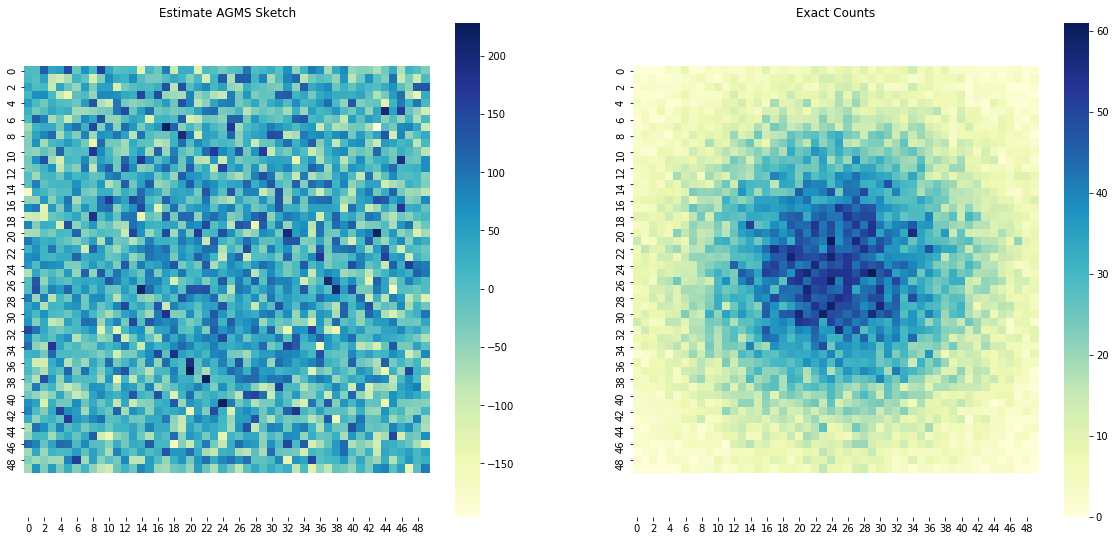

In [72]:
create_and_compare_heatmaps(mean-2*scale, mean+2*scale, mean-2*scale, mean+2*scale, 16, tuple_agms, counts, mean, scale, m)

In [54]:
# def joinSize(stream1, stream2):
# np.empty(5, dtype=object).shape[0]
a = np.random.randint(5, size=(3,5))
b = np.random.randint(3, size=(3,5))


# a = np.ones((4,4))
print(a)
print(b)
print(a*b)

# print(np.average(a, axis=1))

# for ai in a:
#     ai =1
# # print(a**2)
# print(a)

# print(a[b])

# print(b>>1)

# print(randint(0, 1))

# print(-1**b)

# v1 = 1
# c =b&v1
# print(c)
# c[c == 0] = -1
# print(c)




# print(a*b)
# print(np.median(a*b))

[[4 4 2 3 2]
 [0 2 4 3 3]
 [3 2 3 3 1]]
[[2 1 2 2 2]
 [0 0 2 0 2]
 [0 0 1 1 1]]
[[8 4 4 6 4]
 [0 0 8 0 6]
 [0 0 3 3 1]]


# Sketch Generation

In [46]:
# AGMS Sketches
# Uniform
uniform = pd.read_csv('dataGeneration/uniform_int-1-10k-1M.gz', compression='gzip', header=None)
n = 1
numCounters = 1024
numEstimators = 10

agms = AGMS(numCounters, numEstimators)
for element in uniform.values:
    if(n % 100000 == 0):
        print(int(n/100000))
    agms.update(element)
    n+=1
jsonStr = json.dumps(agms.__dict__, indent=2, cls=AGMSEncoder)

text_file = open("json/agms_uniform_int-1-10k-1M.json", "w")
n1 = text_file.write(jsonStr)
text_file.close()
print(jsonStr)

1
2
3
4
5
6
7
8
9
10
{
  "numEstimators": 10, 
  "seed": 42, 
  "numCounters": 1024, 
  "eh3_hashfunctions": {
    "numEstimators": 10, 
    "bits": 30, 
    "S0": [
      [
        413074180, 
        10836377, 
        974532254, 
        257237468, 
        568419704, 
        34456768, 
        546396350, 
        529094803, 
        529908383, 
        424659554, 
        155827498, 
        240903330, 
        900299474, 
        1005089669, 
        50695217, 
        847457729, 
        570633411, 
        498697445, 
        624646838, 
        570919200, 
        116584053, 
        990899375, 
        956915681, 
        34015010, 
        283825304, 
        898850431, 
        625393484, 
        753271476, 
        204307826, 
        838466746, 
        107599222, 
        989735632, 
        99197799, 
        925799041, 
        202436051, 
        621506886, 
        494860297, 
        1004970487, 
        547250888, 
        924224405, 
        964674958, 
        1

In [47]:
# AGMS Sketches
# Normal
normal = pd.read_csv('dataGeneration/normal_int-5k-900-1M.gz', compression='gzip', header=None)
n = 1
numCounters = 1024
numEstimators = 10

agms_normal = AGMS(numCounters, numEstimators)
for element in normal.values:
    if(n % 100000 == 0):
        print(int(n/100000))
    agms_normal.update(element)
    n+=1
jsonStr = json.dumps(agms_normal.__dict__, indent=2, cls=AGMSEncoder)

text_file = open("json/agms_normal_int-5k-900-1M.json", "w")
n1 = text_file.write(jsonStr)
text_file.close()
print(jsonStr)

1
2
3
4
5
6
7
8
9
10
{
  "numEstimators": 10, 
  "seed": 42, 
  "numCounters": 1024, 
  "eh3_hashfunctions": {
    "numEstimators": 10, 
    "bits": 30, 
    "S0": [
      [
        12428930, 
        696950633, 
        1034857047, 
        1002430373, 
        42425703, 
        787134510, 
        430009725, 
        363539754, 
        472562043, 
        56332843, 
        601529871, 
        349473348, 
        448637823, 
        1048716487, 
        191250351, 
        894912593, 
        183215691, 
        1047650664, 
        58685337, 
        65352799, 
        609209638, 
        482748964, 
        987221736, 
        378165439, 
        477256365, 
        344775106, 
        274544314, 
        760123041, 
        532290794, 
        564903698, 
        168890590, 
        441329845, 
        825006502, 
        552342024, 
        165775770, 
        184529026, 
        161002989, 
        716776529, 
        498671654, 
        246432431, 
        160058036, 
       

In [48]:
# AGMS Sketches
# Zipf
zipf = pd.read_csv('dataGeneration/zipf_int-2-1M.gz', compression='gzip', header=None)
n = 1
numCounters = 1024
numEstimators = 10

agms_zipf = AGMS(numCounters, numEstimators)
for element in zipf.values:
    if(n % 100000 == 0):
        print(int(n/100000))
    agms_zipf.update(element)
    n+=1
jsonStr = json.dumps(agms_zipf.__dict__, indent=2, cls=AGMSEncoder)

text_file = open("json/agms_zipf_int-2-1M.json", "w")
n1 = text_file.write(jsonStr)
text_file.close()
print(jsonStr)

1
2
3
4
5
6
7
8
9
10
{
  "numEstimators": 10, 
  "seed": 42, 
  "numCounters": 1024, 
  "eh3_hashfunctions": {
    "numEstimators": 10, 
    "bits": 30, 
    "S0": [
      [
        452820244, 
        98679119, 
        892345361, 
        88407930, 
        630928573, 
        1029408687, 
        81802827, 
        42584980, 
        137703472, 
        834379614, 
        568206037, 
        697985298, 
        508248571, 
        158326045, 
        164890275, 
        275137505, 
        200211082, 
        813121384, 
        266685460, 
        679221996, 
        702861938, 
        454821807, 
        990677595, 
        120014718, 
        1018934428, 
        2138266, 
        1068285665, 
        386570174, 
        532691479, 
        1050953248, 
        139105020, 
        828460359, 
        880621008, 
        918055777, 
        335496401, 
        149022990, 
        210346120, 
        618860692, 
        197438728, 
        1031237615, 
        463470813, 
       

# Heat Map AGMS

In [12]:
# Tuple AGMS Sketches
# Uniform
uniform = pd.read_csv('dataGeneration/2d_uniform_int-1-10k-1M.gz', compression='gzip', header=None)
n = 1
numCounters = 1024
numEstimators = 10

tuple_agms_uniform = TupleAGMS(numCounters, numEstimators)
for element in uniform.values:
    if(n % 100000 == 0):
        print(int(n/100000))
    tuple_agms_uniform.update(element[0], element[1])
    n+=1
jsonStr = json.dumps(tuple_agms_uniform.__dict__, indent=2, cls=AGMSEncoder)

text_file = open("json-2d/agms_2d_uniform_int-1-10k-1M.json", "w")
n1 = text_file.write(jsonStr)
text_file.close()
print(jsonStr)

1
2
3
4
5
6
7
8
9
10
{
  "numEstimators": 10, 
  "x_eh3_hashfunctions": {
    "numEstimators": 10, 
    "bits": 30, 
    "S0": [
      [
        319558820, 
        771860831, 
        870425137, 
        840485327, 
        173383527, 
        511871927, 
        273828665, 
        237256958, 
        607414201, 
        450922287, 
        860680321, 
        391144896, 
        963764071, 
        692973988, 
        248027642, 
        867757296, 
        266723096, 
        282631999, 
        1057825040, 
        941340492, 
        730501671, 
        195614092, 
        978523553, 
        923171844, 
        639608411, 
        244842385, 
        11529277, 
        369002995, 
        299495007, 
        887290298, 
        12537660, 
        550177761, 
        746238858, 
        967348576, 
        689666919, 
        874218771, 
        311925829, 
        359349174, 
        502808093, 
        231023343, 
        32161087, 
        694909597, 
        297269299, 
     

In [13]:
# Tuple AGMS Sketches
# Normal
normal = pd.read_csv('dataGeneration/2d_normal_int-5k-900-1M.gz', compression='gzip', header=None)
n = 1
numCounters = 1024
numEstimators = 10

tuple_agms_normal = TupleAGMS(numCounters, numEstimators)
for element in normal.values:
    if(n % 100000 == 0):
        print(int(n/100000))
    tuple_agms_normal.update(element[0], element[1])
    n+=1
jsonStr = json.dumps(tuple_agms_normal.__dict__, indent=2, cls=AGMSEncoder)

text_file = open("json-2d/agms_2d_normal_int-5k-900-1M.json", "w")
n1 = text_file.write(jsonStr)
text_file.close()
print(jsonStr)

1
2
3
4
5
6
7
8
9
10
{
  "numEstimators": 10, 
  "x_eh3_hashfunctions": {
    "numEstimators": 10, 
    "bits": 30, 
    "S0": [
      [
        126908342, 
        261784269, 
        772101062, 
        1019389812, 
        165312680, 
        171429902, 
        121863255, 
        499686734, 
        284850558, 
        527985105, 
        845108636, 
        441532047, 
        244997955, 
        85558605, 
        730188211, 
        1047568719, 
        592875681, 
        449850669, 
        27050914, 
        797660507, 
        270873274, 
        704808412, 
        682770686, 
        73940303, 
        909905023, 
        1011470188, 
        671898631, 
        23469026, 
        208078788, 
        14651515, 
        956089337, 
        93381510, 
        456987152, 
        822011529, 
        451351326, 
        157867758, 
        320776843, 
        31533384, 
        951709331, 
        687657640, 
        176273994, 
        217814330, 
        627878674, 
       

In [15]:
# Tuple AGMS Sketches
# Zipf
zipf = pd.read_csv('dataGeneration/2d_zipf_int-2-1M.gz', compression='gzip', header=None)
n = 1
numCounters = 1024
numEstimators = 10

tuple_agms_zipf = TupleAGMS(numCounters, numEstimators)
for element in zipf.values:
    if(n % 100000 == 0):
        print(int(n/100000))
    tuple_agms_zipf.update(element[0], element[1])
    n+=1
jsonStr = json.dumps(tuple_agms_zipf.__dict__, indent=2, cls=AGMSEncoder)

text_file = open("json-2d/agms_2d_zipf_int-2-1M.json", "w")
n1 = text_file.write(jsonStr)
text_file.close()
print(jsonStr)

1
2
3
4
5
6
7
8
9
10
{
  "numEstimators": 10, 
  "x_eh3_hashfunctions": {
    "numEstimators": 10, 
    "bits": 30, 
    "S0": [
      [
        187246506, 
        307756793, 
        898435283, 
        789859002, 
        1048205059, 
        133552569, 
        503515492, 
        949433196, 
        752954696, 
        914121370, 
        419825477, 
        723669471, 
        159374508, 
        489056019, 
        351792297, 
        399504309, 
        407601107, 
        880263039, 
        454613225, 
        633348190, 
        135236194, 
        622057670, 
        873114153, 
        965262144, 
        439612637, 
        302277092, 
        229398966, 
        738150309, 
        712802096, 
        708648542, 
        868207124, 
        706064959, 
        307704903, 
        677311567, 
        337367167, 
        92036204, 
        232330866, 
        270773542, 
        263755244, 
        374746323, 
        2245201, 
        544185032, 
        235861191, 
     

# Evaluation Experiments

In [10]:
with open("json/agms_uniform_int-1-10k-1M.json") as f:
    data = json.load(f)
agms_json_uniform = AGMS(0,0,json_dic=data)
for i in np.power(2, np.arange(7,13)):
    print(i)
    result = pd.read_csv('EvaluationExperiments/results/uniform_'+str(i)+'.csv', header=None)
    if i <= 64:
        buckets = calculateBucketRanges(1, 10001, i)
        estimate = agms_json_uniform.query_buckets(buckets)
    else:
        log2 = int(np.log2(i))
        estimate = np.zeros(0)
        for j in np.arange(0, 2**(log2-6)):
            buckets = calculateBucketRanges(j+1, 10001, i)
            curr_estimate = agms_json_uniform.query_buckets(buckets)
            estimate = np.concatenate((estimate, curr_estimate))
#     print(estimate.shape)
    result[1] = estimate
#     counts = counts.T
    result.to_csv('EvaluationExperiments/results/uniform_'+str(i)+'.csv', index=False, header=False)

128
256
512
1024
2048
4096


In [11]:
with open("json/agms_normal_int-5k-900-1M.json") as f:
    data = json.load(f)
agms_json_normal = AGMS(0,0,json_dic=data)
for i in np.power(2, np.arange(7,14)):
    print(i)
    result = pd.read_csv('EvaluationExperiments/results/normal_'+str(i)+'.csv', header=None)
    if i <= 64:
        buckets = calculateBucketRanges(1, 10001, i)
        estimate = agms_json_normal.query_buckets(buckets)
    else:
        log2 = int(np.log2(i))
        estimate = np.zeros(0)
        for j in np.arange(0, 2**(log2-6)):
            buckets = calculateBucketRanges(j+1, 10001, i)
            curr_estimate = agms_json_normal.query_buckets(buckets)
            estimate = np.concatenate((estimate, curr_estimate))
#     print(estimate.shape)
    result[1] = estimate
#     counts = counts.T
    result.to_csv('EvaluationExperiments/results/normal_'+str(i)+'.csv', index=False, header=False)

128
256
512
1024
2048
4096
8192


In [12]:
with open("json/agms_zipf_int-2-1M.json") as f:
    data = json.load(f)
agms_json_zipf = AGMS(0,0,json_dic=data)
for i in np.power(2, np.arange(7,14)):
    print(i)
    result = pd.read_csv('EvaluationExperiments/results/zipf_'+str(i)+'.csv', header=None)
    if i <= 64:
        buckets = calculateBucketRanges(1, 10001, i)
        estimate = agms_json_zipf.query_buckets(buckets)
    else:
        log2 = int(np.log2(i))
        estimate = np.zeros(0)
        for j in np.arange(0, 2**(log2-6)):
            buckets = calculateBucketRanges(j+1, 10001, i)
            curr_estimate = agms_json_zipf.query_buckets(buckets)
            estimate = np.concatenate((estimate, curr_estimate))
#     print(estimate.shape)
    result[1] = estimate
#     counts = counts.T
    result.to_csv('EvaluationExperiments/results/zipf_'+str(i)+'.csv', index=False, header=False)

128
256
512
1024
2048
4096
8192
